##### Imports

In [21]:
import pyspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date
from pyspark.sql import SparkSession, Row, Column
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg, count, explode, split, upper, expr, collect_list, size, split, year, row_number

In [30]:
# spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder \
    .appName("ConsultaPySpark") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

business_path = "data/yelp_academic_dataset_business.json"
review_path = "data/yelp_academic_dataset_review.json"

business_df = spark.read.json(business_path)
review_df = spark.read.json(review_path)

In [30]:
# business.json
{"business_id":"Pns2l4eNsfO8kk83dixA6A",
 "name":"Abby Rappoport, LAC, CMQ",
 "address":"1616 Chapala St, Ste 2",
 "city":"Santa Barbara",
 "state":"CA",
 "postal_code":"93101",
 "latitude":34.4266787,
 "longitude":-119.7111968,
 "stars":5.0,
 "review_count":7,
 "is_open":0,
 "attributes":{"ByAppointmentOnly":"True"},
 "categories":"Doctors, Traditional Chinese Medicine, Naturopathic\/Holistic, Acupuncture, Health & Medical, Nutritionists",
 "hours":null}

# review.json
{"review_id":"KU_O5udG6zpxOg-VcAEodg",
 "user_id":"mh_-eMZ6K5RLWhZyISBhwA",
 "business_id":"XQfwVwDr-v0ZS3_CbbE5Xw",
 "stars":3.0,
 "useful":0,
 "funny":0,
 "cool":0,
 "text":"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.",
 "date":"2018-07-07 22:09:11"}


NameError: name 'null' is not defined

##### 1. Obtener los 10 negocios con mayor número de revisiones (2%)


In [31]:
top_businesses = review_df.groupBy("business_id").agg(count("review_id").alias("num_reviews")) \
    .orderBy(col("num_reviews").desc()).limit(10)

result1 = top_businesses.join(business_df, "business_id").select("name", "num_reviews").orderBy(col("num_reviews").desc())
result1.show()


+--------------------+-----------+
|                name|num_reviews|
+--------------------+-----------+
|   Acme Oyster House|       7673|
|        Oceana Grill|       7516|
|Hattie B’s Hot Ch...|       6160|
|Reading Terminal ...|       5778|
|Ruby Slipper - Ne...|       5264|
| Mother's Restaurant|       5254|
|         Royal House|       5146|
|  Commander's Palace|       4969|
|                Luke|       4661|
|              Cochon|       4480|
+--------------------+-----------+



/tmp/ipykernel_18745/883588996.py:8: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="num_reviews", y="name", data=result1_pd, palette="viridis")


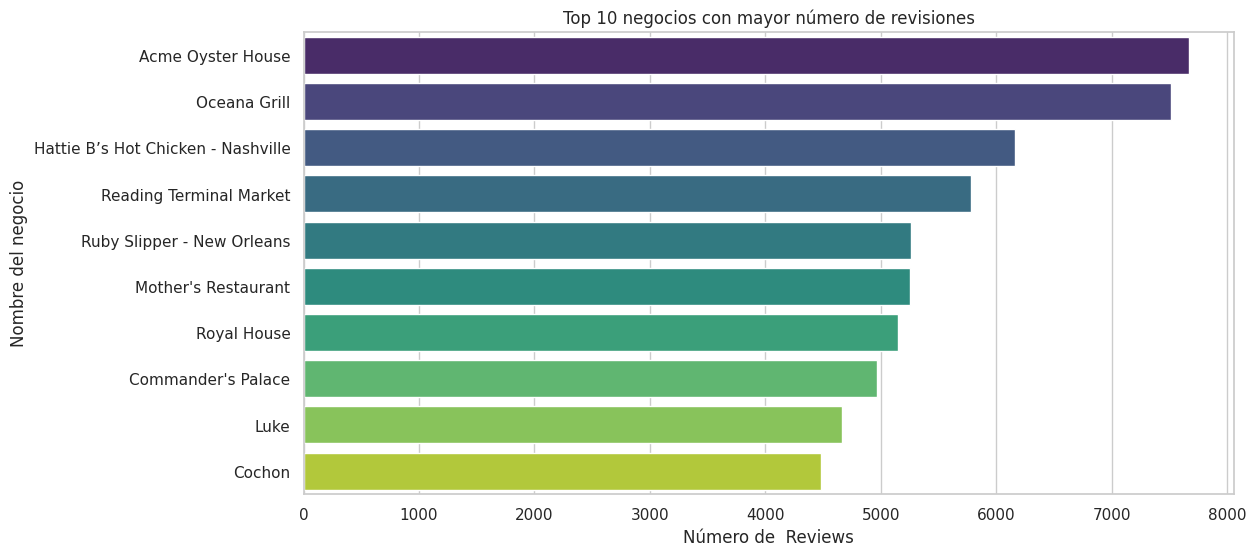

In [32]:
result1_pd = result1.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="num_reviews", y="name", data=result1_pd, palette="viridis")
plt.title("Top 10 negocios con mayor número de revisiones")
plt.xlabel("Número de  Reviews")
plt.ylabel("Nombre del negocio")
plt.show()

##### 2. Obtener las 10 categorías con la mayor puntuación media (2%)


In [33]:
avg_stars_by_category = business_df.select("business_id", "stars", "categories") \
    .withColumn("category", explode(split(col("categories"), ", "))) \
    .groupBy("category").agg(avg("stars").alias("avg_stars")) \
    .orderBy(col("avg_stars").desc()).limit(10) \
    .orderBy(col("category"))

result2 = avg_stars_by_category.show()


+--------------------+---------+
|            category|avg_stars|
+--------------------+---------+
|     Art Consultants|      5.0|
|         Calligraphy|      5.0|
|Cheese Tasting Cl...|      5.0|
|       Childproofing|      5.0|
|         Experiences|      5.0|
|          Patent Law|      5.0|
|        Silent Disco|      5.0|
|              Somali|      5.0|
|Sport Equipment Hire|      5.0|
|     Water Suppliers|      5.0|
+--------------------+---------+



/tmp/ipykernel_18745/1417152152.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_stars", y="category", data=avg_stars_by_category_pd, palette="viridis")


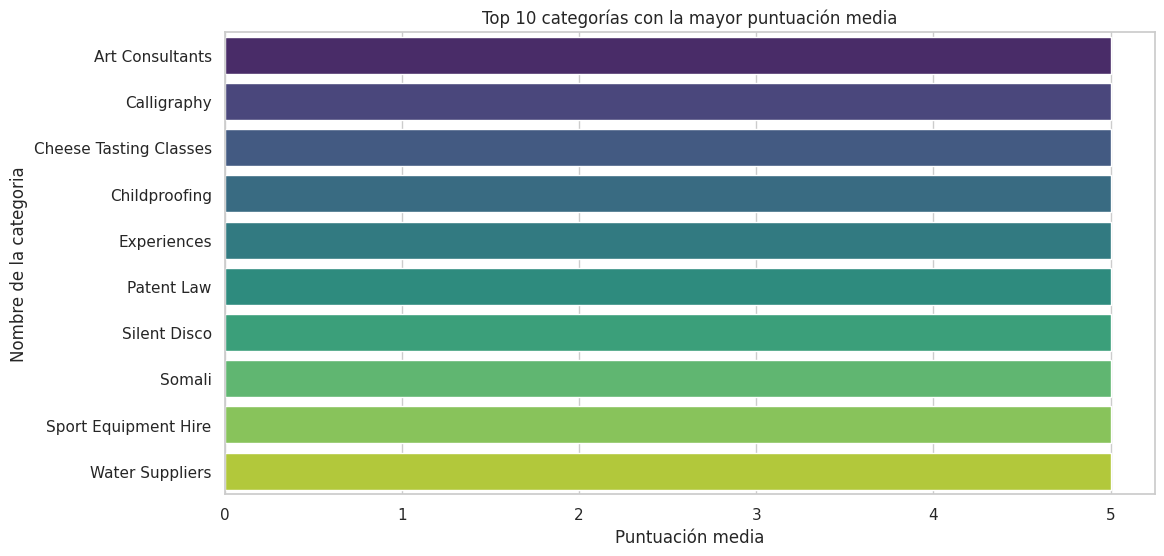

In [34]:
avg_stars_by_category_pd = avg_stars_by_category.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_stars", y="category", data=avg_stars_by_category_pd, palette="viridis")
plt.title("Top 10 categorías con la mayor puntuación media")
plt.xlabel("Puntuación media")
plt.ylabel("Nombre de la categoria")
plt.show()

##### 3. Obtener las 10 ciudades con la mayor puntuación media (2%)


In [35]:
avg_stars_by_city = business_df.select("city", "stars") \
    .groupBy("city").agg(avg("stars").alias("avg_stars")) \
    .orderBy(col("avg_stars").desc()).limit(10) \
    .orderBy(col("city"))

result3 = avg_stars_by_city.show()


+----------------+---------+
|            city|avg_stars|
+----------------+---------+
|         Arizona|      5.0|
| Delaware County|      5.0|
|         Fernley|      5.0|
|        Norriton|      5.0|
|   Pass-a-Grille|      5.0|
|           Reno |      5.0|
|Rosewood Heights|      5.0|
|          SPARKS|      5.0|
|    Webster Grvs|      5.0|
|    phoenixville|      5.0|
+----------------+---------+



/tmp/ipykernel_18745/558502135.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_stars", y="category", data=avg_stars_by_city, palette="viridis")


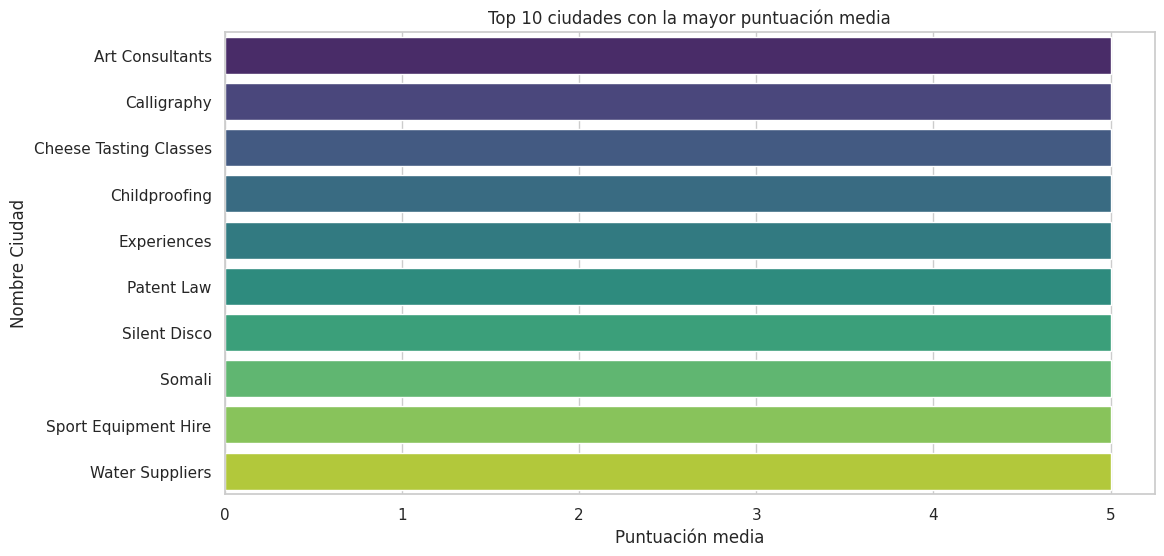

In [36]:
avg_stars_by_city = avg_stars_by_category.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_stars", y="category", data=avg_stars_by_city, palette="viridis")
plt.title("Top 10 ciudades con la mayor puntuación media")
plt.xlabel("Puntuación media")
plt.ylabel("Nombre Ciudad")
plt.show()

##### 4. Calcular la media de palabras para las reseñas de cada puntuación (1-5 estrellas) (2%)


In [37]:
# Calcular la media de palabras para las reseñas de cada puntuación (1-5 estrellas)
avg_words_by_stars = review_df.groupBy("stars").agg(avg(size(split(col("text"), " "))).alias("avg_words"))

result4 = avg_words_by_stars.show()


+-----+------------------+
|stars|         avg_words|
+-----+------------------+
|  1.0| 135.3761664832581|
|  4.0|109.01844357355336|
|  3.0|125.33368066896554|
|  2.0|135.76835403498455|
|  5.0| 85.32756936366728|
+-----+------------------+



/tmp/ipykernel_18745/395357095.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="stars", y="avg_words", data=avg_words_by_stars_pd, palette="viridis")


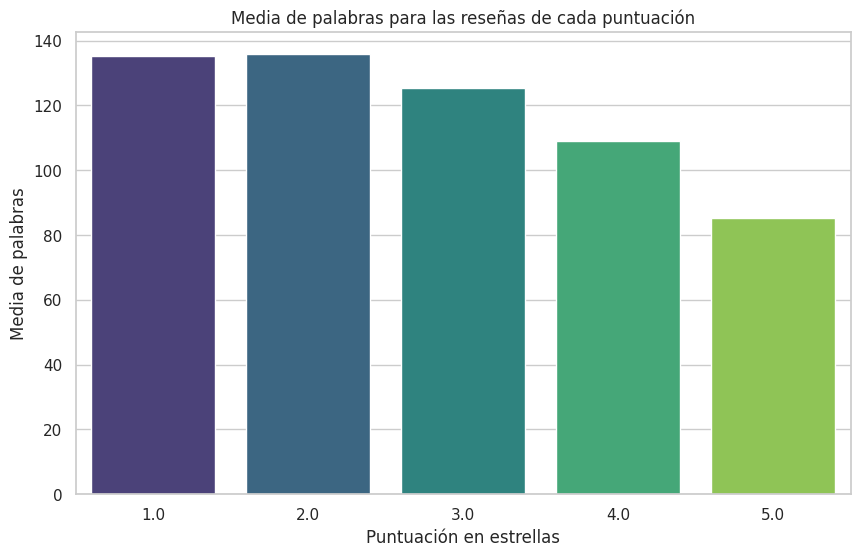

In [58]:
avg_words_by_stars_pd = avg_words_by_stars.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="stars", y="avg_words", data=avg_words_by_stars_pd, palette="viridis")
plt.title("Media de palabras para las reseñas de cada puntuación")
plt.xlabel("Puntuación en estrellas")
plt.ylabel("Media de palabras")
plt.show()

##### 5. Obtener las 10 categorías que más se repiten para cada puntuación (1-5 estrellas) (4%)


###### Creo que esta mal

In [39]:
# Filtrar las reseñas por puntuaciónes de estrellas
one_star_reviews    = review_df.filter(col("stars") == 1)
two_star_reviews    = review_df.filter(col("stars") == 2)
three_star_reviews  = review_df.filter(col("stars") == 3)
four_star_reviews   = review_df.filter(col("stars") == 4)
five_star_reviews   = review_df.filter(col("stars") == 5)

# Obtener las categorías que más se repiten para la puntuación de 1 estrella
top_categories_for_one_star = (
    one_star_reviews
    .join(business_df, "business_id")
    .select(explode(split("categories", ", ")).alias("category"))
    .groupBy("category")
    .agg(count("*").alias("count"))
    .orderBy(col("count").desc())
    .limit(10)
)

top_categories_for_two_star = (
    two_star_reviews
    .join(business_df, "business_id")
    .select(explode(split("categories", ", ")).alias("category"))
    .groupBy("category")
    .agg(count("*").alias("count"))
    .orderBy(col("count").desc())
    .limit(10)
)

top_categories_for_three_star = (
    three_star_reviews
    .join(business_df, "business_id")
    .select(explode(split("categories", ", ")).alias("category"))
    .groupBy("category")
    .agg(count("*").alias("count"))
    .orderBy(col("count").desc())
    .limit(10)
)

top_categories_for_four_star = (
    four_star_reviews
    .join(business_df, "business_id")
    .select(explode(split("categories", ", ")).alias("category"))
    .groupBy("category")
    .agg(count("*").alias("count"))
    .orderBy(col("count").desc())
    .limit(10)
)

top_categories_for_five_star = (
    five_star_reviews
    .join(business_df, "business_id")
    .select(explode(split("categories", ", ")).alias("category"))
    .groupBy("category")
    .agg(count("*").alias("count"))
    .orderBy(col("count").desc())
    .limit(10)
)

top_categories_for_one_star.show()
top_categories_for_two_star.show()
top_categories_for_three_star.show()
top_categories_for_four_star.show()
top_categories_for_five_star.show()


+--------------------+------+
|            category| count|
+--------------------+------+
|         Restaurants|567185|
|                Food|200062|
|           Nightlife|171310|
|                Bars|160744|
|American (Traditi...|135761|
|            Shopping|110161|
|      American (New)| 98740|
|Event Planning & ...| 91701|
|  Breakfast & Brunch| 89419|
|             Burgers| 81299|
+--------------------+------+



+--------------------+------+
|            category| count|
+--------------------+------+
|         Restaurants|404486|
|                Food|135015|
|           Nightlife|134947|
|                Bars|128301|
|American (Traditi...| 98551|
|      American (New)| 85894|
|  Breakfast & Brunch| 69261|
|          Sandwiches| 55881|
|Event Planning & ...| 54730|
|             Seafood| 53573|
+--------------------+------+



+--------------------+------+
|            category| count|
+--------------------+------+
|         Restaurants|543108|
|           Nightlife|190844|
|                Food|189080|
|                Bars|181185|
|American (Traditi...|130179|
|      American (New)|120373|
|  Breakfast & Brunch| 98102|
|          Sandwiches| 76597|
|             Seafood| 72147|
|Event Planning & ...| 67623|
+--------------------+------+



+--------------------+-------+
|            category|  count|
+--------------------+-------+
|         Restaurants|1130251|
|                Food| 421154|
|           Nightlife| 388516|
|                Bars| 368122|
|American (Traditi...| 248110|
|      American (New)| 247218|
|  Breakfast & Brunch| 210449|
|          Sandwiches| 164547|
|             Seafood| 147859|
|Event Planning & ...| 131959|
+--------------------+-------+



+--------------------+-------+
|            category|  count|
+--------------------+-------+
|         Restaurants|2079441|
|                Food| 868282|
|           Nightlife| 654140|
|                Bars| 617201|
|      American (New)| 432315|
|  Breakfast & Brunch| 400199|
|American (Traditi...| 399045|
|          Sandwiches| 317516|
|             Seafood| 281802|
|Event Planning & ...| 263540|
+--------------------+-------+



###### Deberia estar bien

In [53]:
windowSpec = Window.partitionBy("stars").orderBy(col("count").desc())

top_categories_by_stars = (
    review_df
    .join(business_df, "business_id")
    .select("stars", explode(split("categories", ", ")).alias("category"))
    .groupBy("stars", "category")
    .agg(count("*").alias("count"))
    .withColumn("row_number", row_number().over(windowSpec))
    .filter(col("row_number") <= 10)
    .drop("row_number")
    .orderBy("stars", col("count").desc())
)

top_categories_by_stars.show(500)

+-----+--------------------+-------+
|stars|            category|  count|
+-----+--------------------+-------+
|  1.0|       Home Services|   9411|
|  1.0|      Local Services|   5181|
|  1.0|         Restaurants|   3611|
|  1.0|            Shopping|   3330|
|  1.0|Professional Serv...|   3061|
|  1.0|     Hotels & Travel|   2903|
|  1.0|           Fast Food|   2776|
|  1.0|         Real Estate|   2775|
|  1.0|                Food|   2343|
|  1.0|    Health & Medical|   2313|
|  1.5|         Restaurants|  36318|
|  1.5|           Fast Food|  25799|
|  1.5|       Home Services|  19548|
|  1.5|                Food|  19038|
|  1.5|             Burgers|  18315|
|  1.5|     Hotels & Travel|  15144|
|  1.5|            Shopping|  13418|
|  1.5|      Local Services|  12354|
|  1.5|        Coffee & Tea|  11023|
|  1.5|          Automotive|   8950|
|  2.0|         Restaurants|  82529|
|  2.0|                Food|  36474|
|  2.0|           Fast Food|  34962|
|  2.0|            Shopping|  32258|
|

/tmp/ipykernel_18745/3597304530.py:8: FutureWarning:                            

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="stars", y="count", hue="category", data=top_categories_pd, palette="viridis", ci=None)


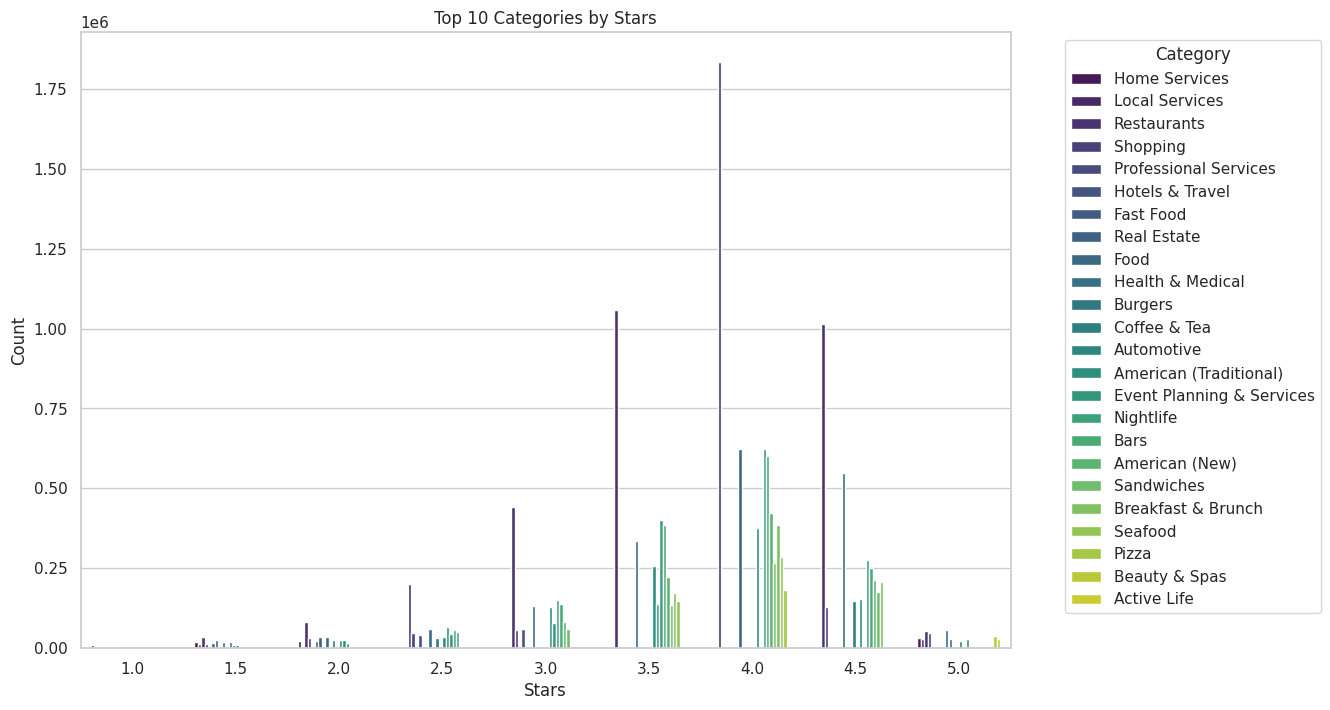

In [54]:
top_categories_pd = top_categories_by_stars.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras apiladas utilizando Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x="stars", y="count", hue="category", data=top_categories_pd, palette="viridis", ci=None)
plt.title("Categorías que más se repiten para cada puntuación")
plt.xlabel("Puntuación en estrellas")
plt.ylabel("Recuento de categorias")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


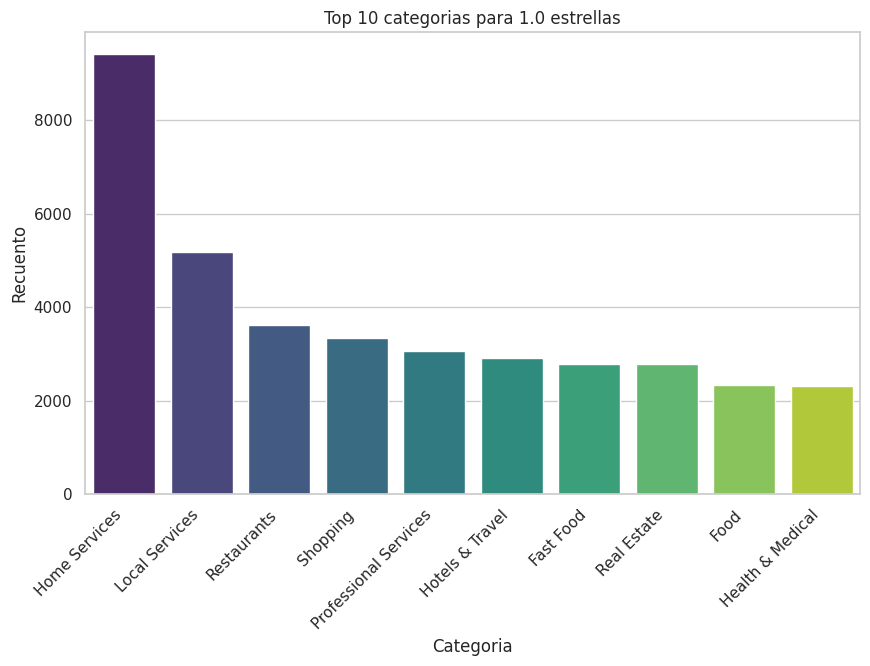

/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


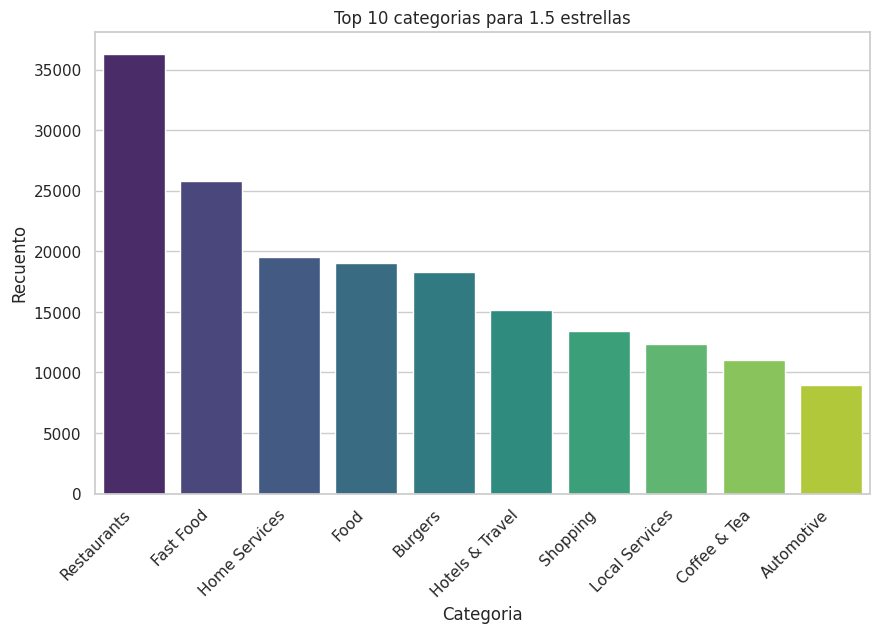

/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


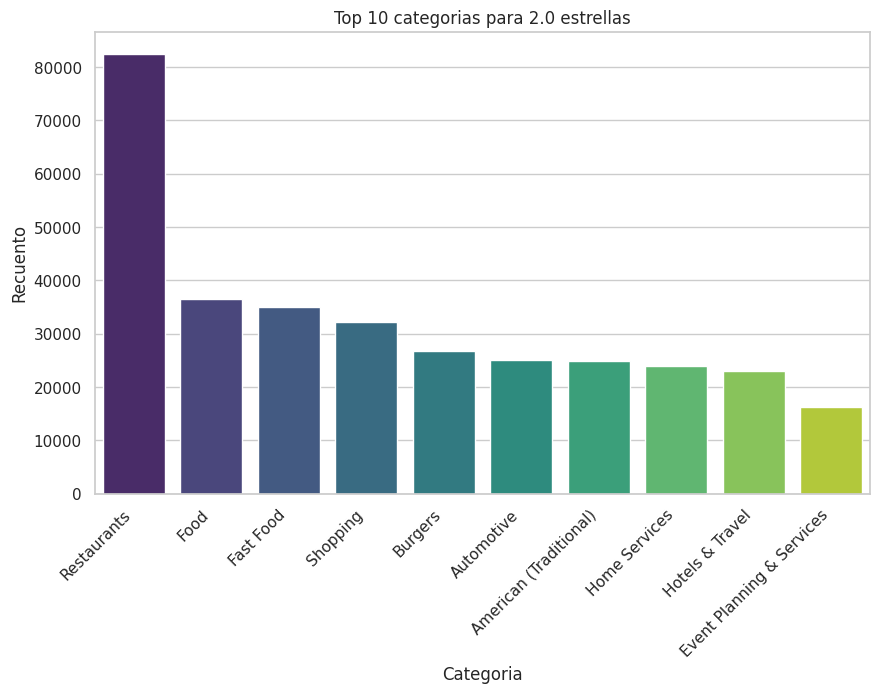

/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


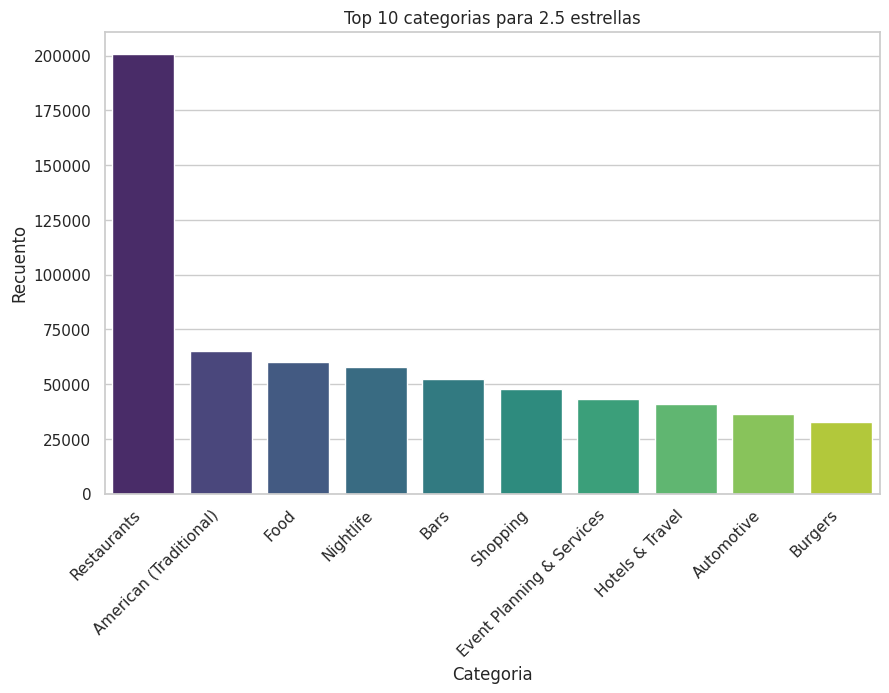

/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


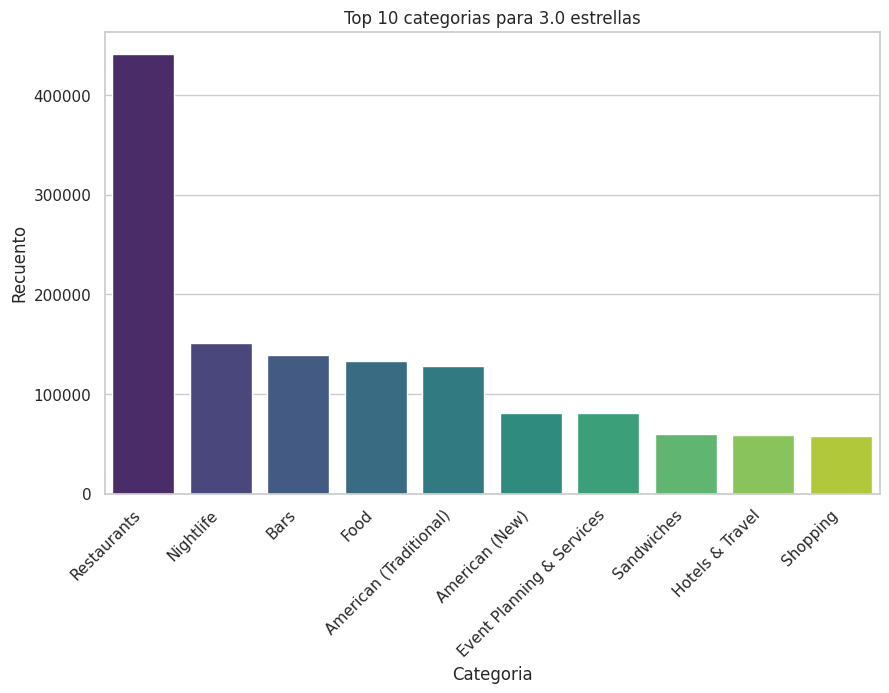

/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


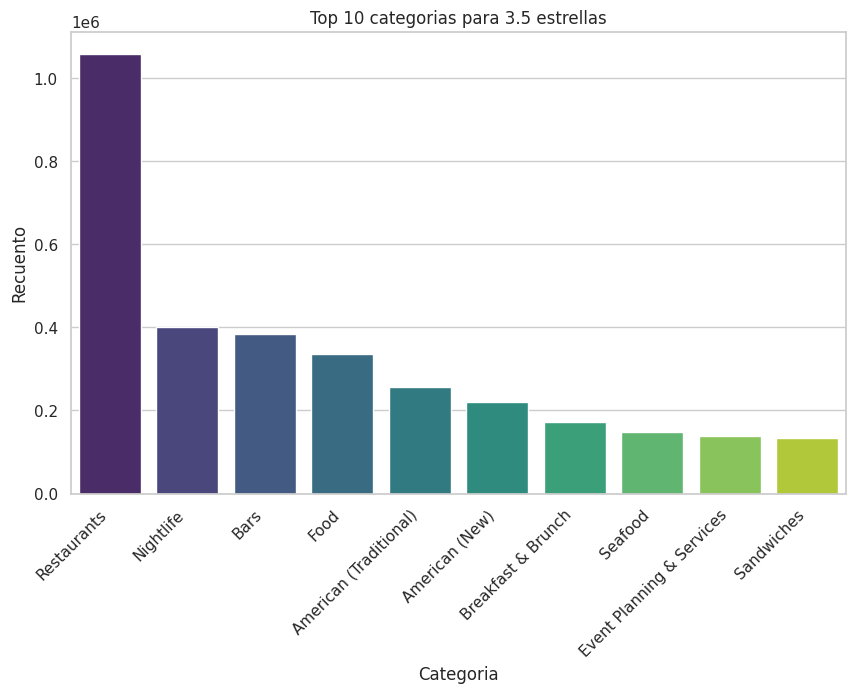

/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


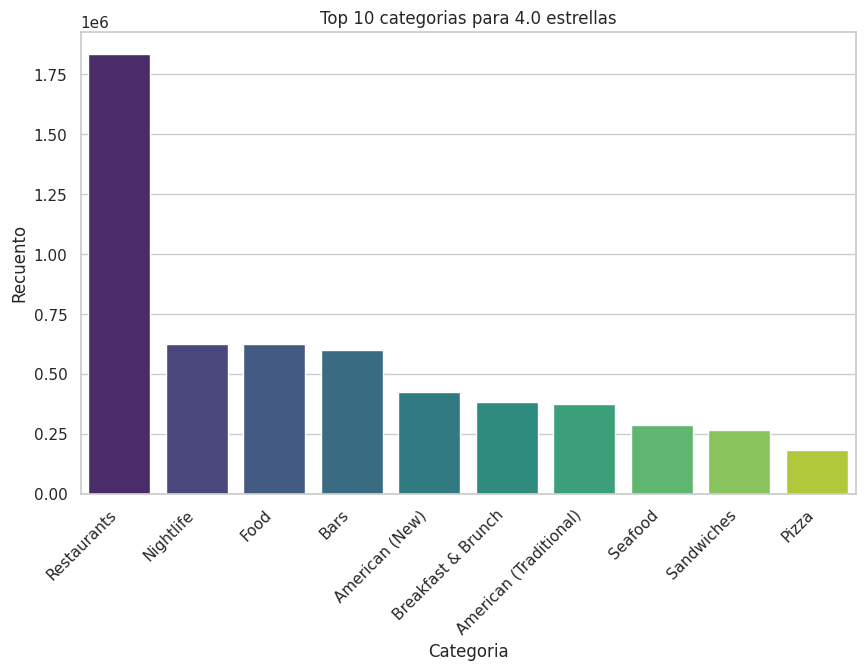

/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


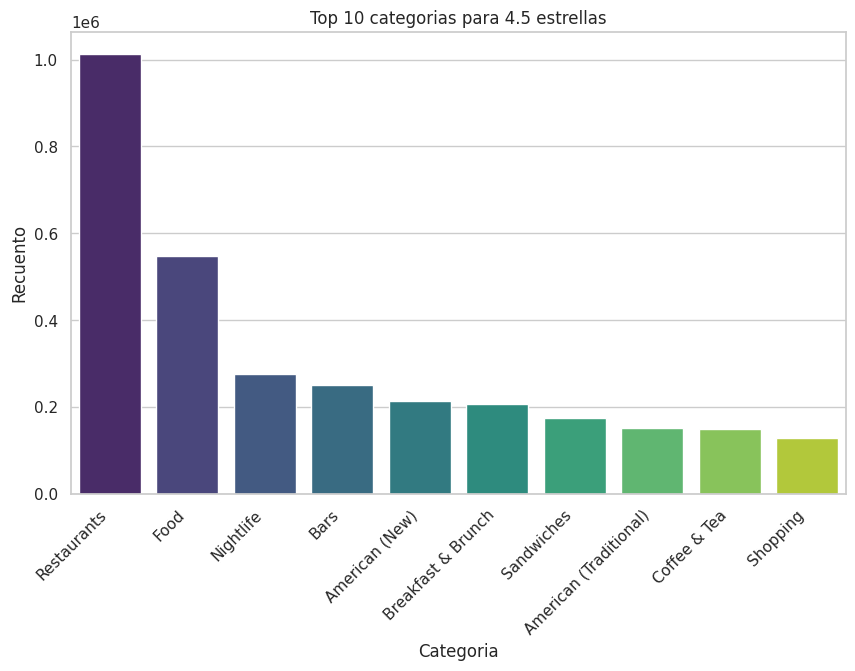

/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_18745/1673855139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


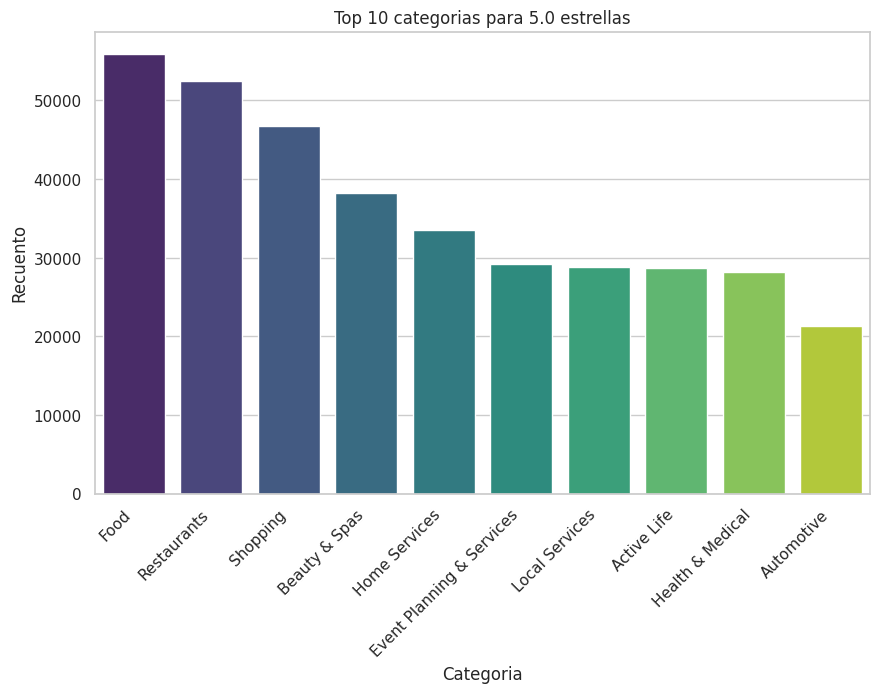

In [56]:
top_categories_pd = top_categories_by_stars.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras apiladas para cada valor de puntuación
for star_value in top_categories_pd['stars'].unique():
    plt.figure(figsize=(10, 6))
    subset_df = top_categories_pd[top_categories_pd['stars'] == star_value]
    sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
    plt.title(f"Top 10 categorias para {star_value} estrellas")
    plt.xlabel("Categoria")
    plt.ylabel("Recuento")
    plt.xticks(rotation=45, ha="right")
    plt.show()

##### 6. Analizar cómo un atributo determinado afecta a la puntuación del negocio (4%)


In [46]:
#  Se refiere al campo "atributo" o a uyna columna cualqueira WTF EMALDI

attribute_effect = business_df.select("stars", "attributes.ByAppointmentOnly") \
    .groupBy("ByAppointmentOnly").agg(avg("stars").alias("avg_stars"))

result6 = attribute_effect.show()


+-----------------+------------------+
|ByAppointmentOnly|         avg_stars|
+-----------------+------------------+
|             None|              3.45|
|            False|3.7063694267515923|
|             null|3.5178923588285946|
|             True|3.9550900121724646|
+-----------------+------------------+



/tmp/ipykernel_18745/656211388.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ByAppointmentOnly", y="avg_stars", data=attribute_effect_pd, palette="viridis")


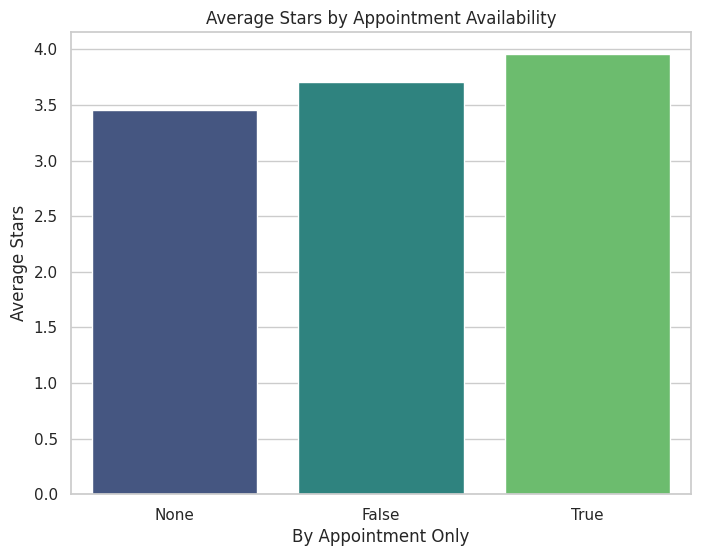

In [47]:
attribute_effect_pd = attribute_effect.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x="ByAppointmentOnly", y="avg_stars", data=attribute_effect_pd, palette="viridis")
plt.title("Average Stars by Appointment Availability")
plt.xlabel("By Appointment Only")
plt.ylabel("Average Stars")
plt.show()

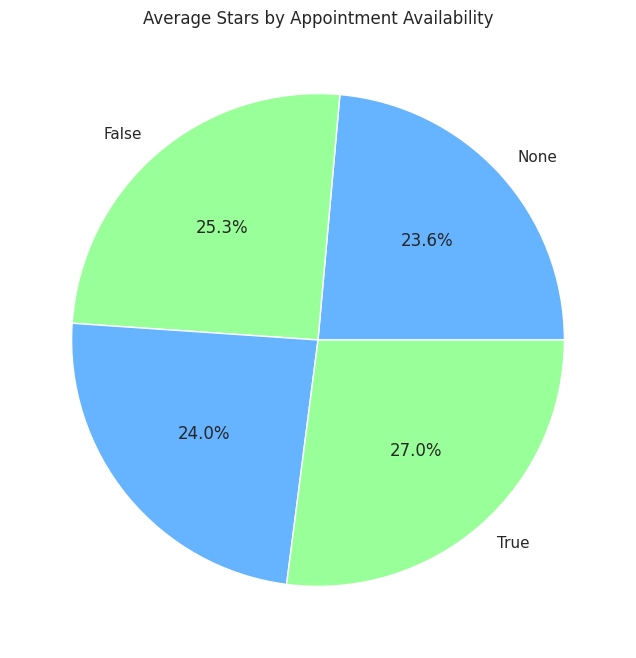

In [48]:
attribute_effect_pd = attribute_effect.toPandas()

# Crear un gráfico de quesos utilizando Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(attribute_effect_pd['avg_stars'], labels=attribute_effect_pd['ByAppointmentOnly'], autopct='%1.1f%%', colors=['#66b3ff','#99ff99'])
plt.title('Average Stars by Appointment Availability')
plt.show()

##### 7. Obtener la media anual de puntuación para las 10 categorías con mayor número de reseñas (4%)

In [41]:
# Obtener las 10 categorías con mayor número de reseñas
top_categories_by_reviews = (
    review_df
    .join(business_df, "business_id")
    .select(explode(split("categories", ", ")).alias("category"))
    .groupBy("category")
    .agg(count("*").alias("num_reviews"))
    .orderBy(col("num_reviews").desc())
    .limit(10)
)

# Renombrar la columna "stars" de review_df a "review_stars"
review_df = review_df.withColumnRenamed("stars", "review_stars")

# Filtrar las reseñas para las categorías seleccionadas
filtered_reviews = (
    review_df
    .join(business_df, "business_id")
    .select("review_stars", "date", explode(split("categories", ", ")).alias("category"))
    .join(top_categories_by_reviews, "category")
)

# Agregar una columna de año y calcular la media anual de puntuación para las 10 categorías con mayor número de reseñas
windowSpec = Window.partitionBy("category", "year").orderBy("year")

result = (
    filtered_reviews
    .withColumn("year", year("date"))
    .groupBy("category", "year")
    .agg(avg(col("review_stars")).alias("avg_stars"))
    .withColumn("row_number", row_number().over(windowSpec))
    .filter(col("row_number") == 1)
    .drop("row_number")
    .orderBy("category", "year")
)

result.show(400)

+--------------------+----+------------------+
|            category|year|         avg_stars|
+--------------------+----+------------------+
|      American (New)|2005| 4.086956521739131|
|      American (New)|2006|  4.05607476635514|
|      American (New)|2007| 3.885222381635581|
|      American (New)|2008| 3.790946896992962|
|      American (New)|2009| 3.693454925429847|
|      American (New)|2010| 3.714959175738725|
|      American (New)|2011|3.7084460042575227|
|      American (New)|2012| 3.705262675766042|
|      American (New)|2013| 3.708643879037094|
|      American (New)|2014|3.7905753274017795|
|      American (New)|2015|3.8261306721544086|
|      American (New)|2016| 3.854635336531896|
|      American (New)|2017|3.8659174072138005|
|      American (New)|2018| 3.887391530984577|
|      American (New)|2019|3.8899515208575934|
|      American (New)|2020| 3.967351756925017|
|      American (New)|2021| 3.894207115460918|
|      American (New)|2022|3.9226490066225166|
|American (Tr

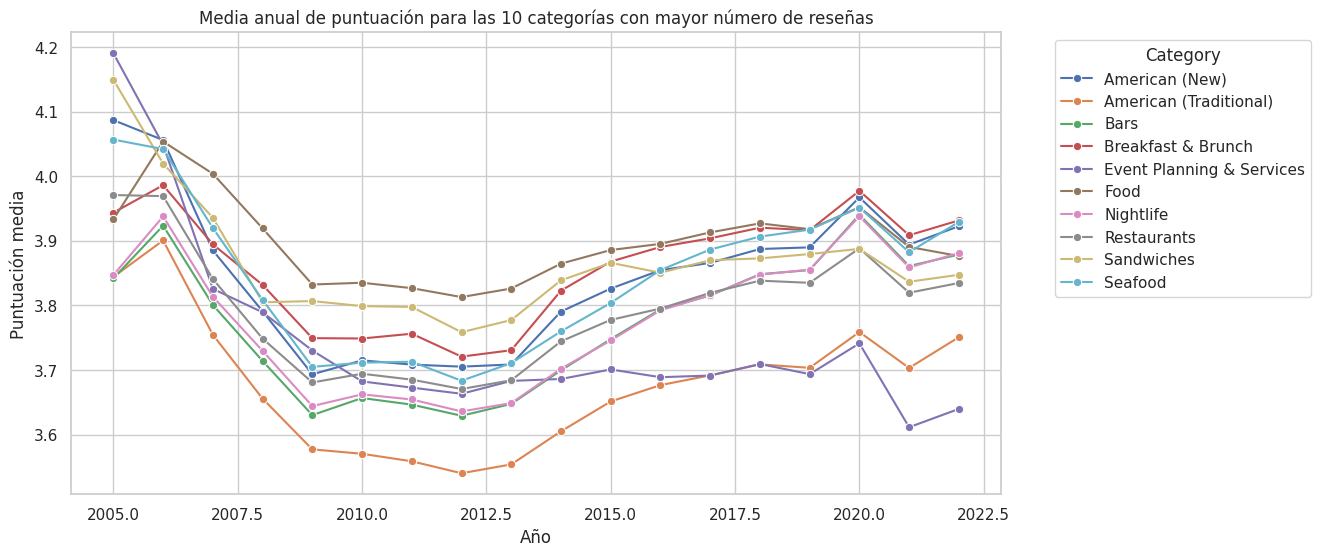

In [51]:
result_pd = result.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de líneas utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="year", y="avg_stars", hue="category", data=result_pd, marker="o")
plt.title("Media anual de puntuación para las 10 categorías con mayor número de reseñas")
plt.xlabel("Año")
plt.ylabel("Puntuación media")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### EXTRA

In [43]:
# NO es el bueno pero es importtante (creo)
# Obtener las 10 categorías con mayor número de reseñas
top_categories_by_reviews = (
    review_df
    .join(business_df, "business_id")
    .select(explode(split("categories", ", ")).alias("category"))
    .groupBy("category")
    .agg(count("*").alias("num_reviews"))
    .orderBy(col("num_reviews").desc())
    .limit(10)
)

# Renombrar la columna "stars" de review_df a "review_stars"
review_df = review_df.withColumnRenamed("stars", "review_stars")

# Filtrar las reseñas para las categorías seleccionadas
filtered_reviews = (
    review_df
    .join(business_df, "business_id")
    .select("review_stars", explode(split("categories", ", ")).alias("category"))
    .join(top_categories_by_reviews, "category")
)

# Calcular la media y el número de reseñas para las 10 categorías con mayor número de reseñas
avg_stars_and_reviews_by_category = (
    filtered_reviews
    .groupBy("category")
    .agg(avg(col("review_stars")).alias("avg_stars"), count("*").alias("num_reviews"))
    .orderBy("category")
)

avg_stars_and_reviews_by_category.show()


+--------------------+------------------+-----------+
|            category|         avg_stars|num_reviews|
+--------------------+------------------+-----------+
|      American (New)|3.8414833323176305|     984540|
|American (Traditi...|3.6683434719259504|    1011646|
|                Bars| 3.791956733969838|    1455553|
|  Breakfast & Brunch|3.8793193687098673|     867430|
|Event Planning & ...|3.6905174775614262|     609553|
|                Food|  3.89467647923211|    1813593|
|           Nightlife| 3.791832087790476|    1539757|
|         Restaurants|3.7937982897979476|    4724471|
|          Sandwiches| 3.851398540753674|     691864|
|             Seafood| 3.851528503966968|     620247|
+--------------------+------------------+-----------+

